In [12]:
import pandas as pd
import requests
from tqdm import tqdm
from bs4 import BeautifulSoup
from unidecode import unidecode
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from multiprocessing import Pool
import tqdm

year = '2020'

def get_score(row):
    score = row.stars if not row.stars == '' else 0
    if len(row['github']) > 0:
        score += 0.5
    return score

def get_paper_info():
    print('Getting paper info...')
    info = {}
    base_url = 'http://openaccess.thecvf.com/CVPR%s.py' % year
    soup = BeautifulSoup(requests.get(base_url).content, "html.parser")
    for a in tqdm.tqdm(soup.find_all('a')):
        link = a.get('href')
        if link is None or link[-5:] != '.html':
            continue
        link = "http://openaccess.thecvf.com/{}".format(a.get('href'))
        paper = BeautifulSoup(requests.get(link).content, "html.parser")
        title = unidecode(paper.find('div', {'id': 'papertitle'}).text.lstrip())
        authors = unidecode(paper.find('i').text).split(',  ')
        abstract = unidecode(paper.find('div', {'id': 'abstract'}).text.strip())
        info[title.lower()] = {'authors': authors, 'abstract': abstract, 'title': title}
    return info

def get_row(row):
    return {'author': row['authors'][0],
        'github': row['github'] if 'github' in row else '',
        'stars': row['stars'] if 'stars' in row else '',
        'task 1': row['tasks'][0] if 'stars' in row and row['tasks'][0] is not None else '',
        'task 2': row['tasks'][1] if 'stars' in row and row['tasks'][1] is not None else '',
        'task 3': row['tasks'][2] if 'stars' in row and row['tasks'][2] is not None else '',
        'title': row['title'],
        }


def get_github(rowi):
    row = info[rowi]
    # print(row)
    url = 'https://paperswithcode.com/search?q={}'.format(row['title'].replace(' ', '+'))
    results = BeautifulSoup(requests.get(url).content, 'html.parser')
    has_code = []
    for res in results.find_all('div', {'class': 'infinite-item'}):
        link = res.find('a', {'class': 'badge-dark'})
        if unidecode(link.text.strip()) == 'Code':
            has_code.append('https://paperswithcode.com{}'.format(link.get('href')))
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform([row['abstract']]).A
    Y = []
    papers = []
    tasks = np.empty(5, dtype=object)
    for link in has_code:
        paper = BeautifulSoup(requests.get(link).content, 'html.parser')
        papers.append(paper)
        paperabs = unidecode(paper.find('div', {'class': 'paper-abstract'}).find('p').text.strip().replace('\n', ' ').replace('...', ' ').replace(' (read more)', ''))
        Y.append(paperabs)

        results = paper.find('div', {'class': 'col-md-5 paper-section'}).find('div', {'class': 'paper-section-title'}).find('div', {'class': 'paper-tasks'}).find_all('ul', {'class':'list-unstyled'})
        for idx, tmp in enumerate(results):
            task = tmp.find('a').get('href').split('/')[-1]
            tasks[idx] = task

    if len(Y) > 0:
        Y = vectorizer.transform(Y).A
        scores = np.matmul(Y, X.T)[:,0]
        best_ix = np.argmax(scores)
        if scores[best_ix] > .85:
            paper = papers[best_ix]
            code = paper.find('div', {'class': 'paper-implementations'}).find('div', {'class': 'row'})
            github = code.find('a', {'class': 'code-table-link'}).get('href')
            stars = int(unidecode(code.find_all('div', {'class': 'paper-impl-cell'})[1].text).strip().replace(' ', '').replace(',', ''))
            return rowi, {'github': github, 'stars': stars, 'tasks': tasks}
 
    return rowi, {}


## Step 1. Get paper information

In [6]:
paper_info_filename = 'CVPR%s_paper_info.npy' % year
try:
    info = np.load(paper_info_filename).tolist()
    print('Load paper information for CVPR %s successfully' % year)
except:
    info = get_paper_info()
    np.save(paper_info_filename, info)
    print('Save paper information for CVPR %s successfully' % year)

getting paper info...
100%|██████████| 12248/12248 [11:30<00:00, 17.73it/s]Save paper information for CVPR 2020 successfully



## Step 2. Get github information

In [7]:
print('Getting github info...')
github_info_filename = 'CVPR%s_github_info.npy' % year
try:
    github_info = np.load(github_info_filename).tolist()
    print('Load github information for CVPR %s successfully' % year)
except:
    github_info = {}
#     tmp = list(info.keys())[:20]
    for key in tqdm.tqdm(info.keys()):
        try:
            row, single_info = get_github(key)
            github_info[row] = single_info
        except:
            print('Failed in paper:', key)
    np.save(github_info_filename, github_info)
    print('Save github information for CVPR %s successfully' % year)

100%|██████████| 1467/1467 [40:28<00:00,  1.66s/it]Save github information for CVPR 2020 successfully



In [17]:
for k, val in github_info.items():
    info[k].update(val)

## Step 3. Save to csv files

In [18]:
list(info.items())[0]

('unsupervised learning of probably symmetric deformable 3d objects from images in the wild',
 {'abstract': 'We propose a method to learn 3D deformable object categories from raw single-view images, without external supervision. The method is based on an autoencoder that factors each input image into depth, albedo, viewpoint and illumination. In order to disentangle these components without supervision, we use the fact that many object categories have, at least in principle, a symmetric structure. We show that reasoning about illumination allows us to exploit the underlying object symmetry even if the appearance is not symmetric due to shading. Furthermore, we model objects that are probably, but not certainly, symmetric by predicting a symmetry probability map, learned end-to-end with the other components of the model. Our experiments show that this method can recover very accurately the 3D shape of human faces, cat faces and cars from single-view images, without any supervision or a 

In [47]:
info_result = map(get_row, info.values())
df = pd.DataFrame(info_result)
df['score'] = df.apply(get_score, axis=1)
df = df.sort_values(['score', 'github'], ascending=False)
df = df[['title', 'author', 'task 1', 'task 2', 'task 3', 'github', 'stars']]
df.index = range(1, len(df) + 1)
outname = 'CVPR%s_info.csv' % year
print('Saving to ', outname)
df.to_csv(outname)

Saving to  CVPR2020_info.csv


In [20]:
df

,title,author,task 1,task 2,task 3,github,stars
1,Context R-CNN: Long Term Temporal Context for ...,Sara Beery,object-detection,video-understanding,,https://github.com/tensorflow/models/tree/mast...,64576
2,MnasFPN: Learning Latency-Aware Pyramid Archit...,Bo Chen,object-detection,,,https://github.com/tensorflow/models/tree/mast...,64576
3,Google Landmarks Dataset v2 - A Large-Scale Be...,Tobias Weyand,image-retrieval,transfer-learning,,https://github.com/tensorflow/models/tree/mast...,64576
4,PointRend: Image Segmentation As Rendering,Alexander Kirillov,semantic-segmentation,,,https://github.com/facebookresearch/detectron2...,11147
5,Distilling Effective Supervision From Severe L...,Zizhao Zhang,image-classification,,,https://github.com/google-research/google-rese...,10588
6,Bridging the Gap Between Anchor-Based and Anch...,Shifeng Zhang,object-detection,,,https://github.com/open-mmlab/mmdetection,10263
7,Analyzing and Improving the Image Quality of S...,Tero Karras,image-generation,,,https://github.com/NVlabs/stylegan2,4713
8,SpineNet: Learning Scale-Permuted Backbone for...,Xianzhi Du,instance-segmentation,architecture-search,object-detection,https://github.com/tensorflow/tpu/tree/master/...,3585
9,Self-Training With Noisy Student Improves Imag...,Qizhe Xie,data-augmentation,image-classification,,https://github.com/tensorflow/tpu/tree/master/...,3582
10,EfficientDet: Scalable and Efficient Object De...,Mingxing Tan,object-detection,object-detection-in-aerial-images,pedestrian-detection,https://github.com/zylo117/Yet-Another-Efficie...,3441


## 4. Topics anaysis

In [21]:
topics_list = df['task 1'].tolist() + df['task 2'].tolist() + df['task 3'].tolist()
all_topics= set(topics_list)
all_topics

{'',
 '3d-absolute-human-pose-estimation',
 '3d-face-reconstruction',
 '3d-human-action-recognition',
 '3d-human-pose-estimation',
 '3d-instance-segmentation-1',
 '3d-multi-object-tracking',
 '3d-object-classification',
 '3d-object-detection',
 '3d-object-detection-from-stereo-images',
 '3d-object-reconstruction',
 '3d-object-reconstruction-from-a-single-image',
 '3d-pose-estimation',
 '3d-reconstruction',
 '3d-semantic-instance-segmentation',
 '3d-semantic-segmentation',
 '3d-shape-analysis',
 '3d-shape-recognition',
 '3d-shape-reconstruction',
 '3d-shape-representation',
 '3d-shape-retrieval',
 '6d-pose-estimation',
 '6d-pose-estimation-1',
 'action-classification',
 'action-detection',
 'action-localization',
 'action-recognition',
 'action-recognition-in-videos',
 'action-segmentation',
 'action-spotting',
 'active-learning',
 'adversarial-attack',
 'adversarial-defense',
 'anomaly-detection',
 'architecture-search',
 'autonomous-driving',
 'autonomous-navigation',
 'autonomous-veh

In [40]:
from collections import Counter
import matplotlib.pyplot as plt
keyword_counter = Counter(topics_list)

In [41]:
topic_count = pd.DataFrame([(ele, keyword_counter[ele]) for ele in keyword_counter], columns=['topic', 'count']).sort_values(by=['count'], ascending=False)
topic_count.to_csv('CVPR%s_topic_count.csv' % year)
topic_count

,topic,count
8,,3443
0,object-detection,57
2,semantic-segmentation,49
3,image-classification,32
4,image-generation,26
83,pose-estimation,25
5,instance-segmentation,22
61,architecture-search,20
57,optical-flow-estimation,17
1,image-retrieval,16


In [42]:
keyword_counter['image-super-resolution']

9

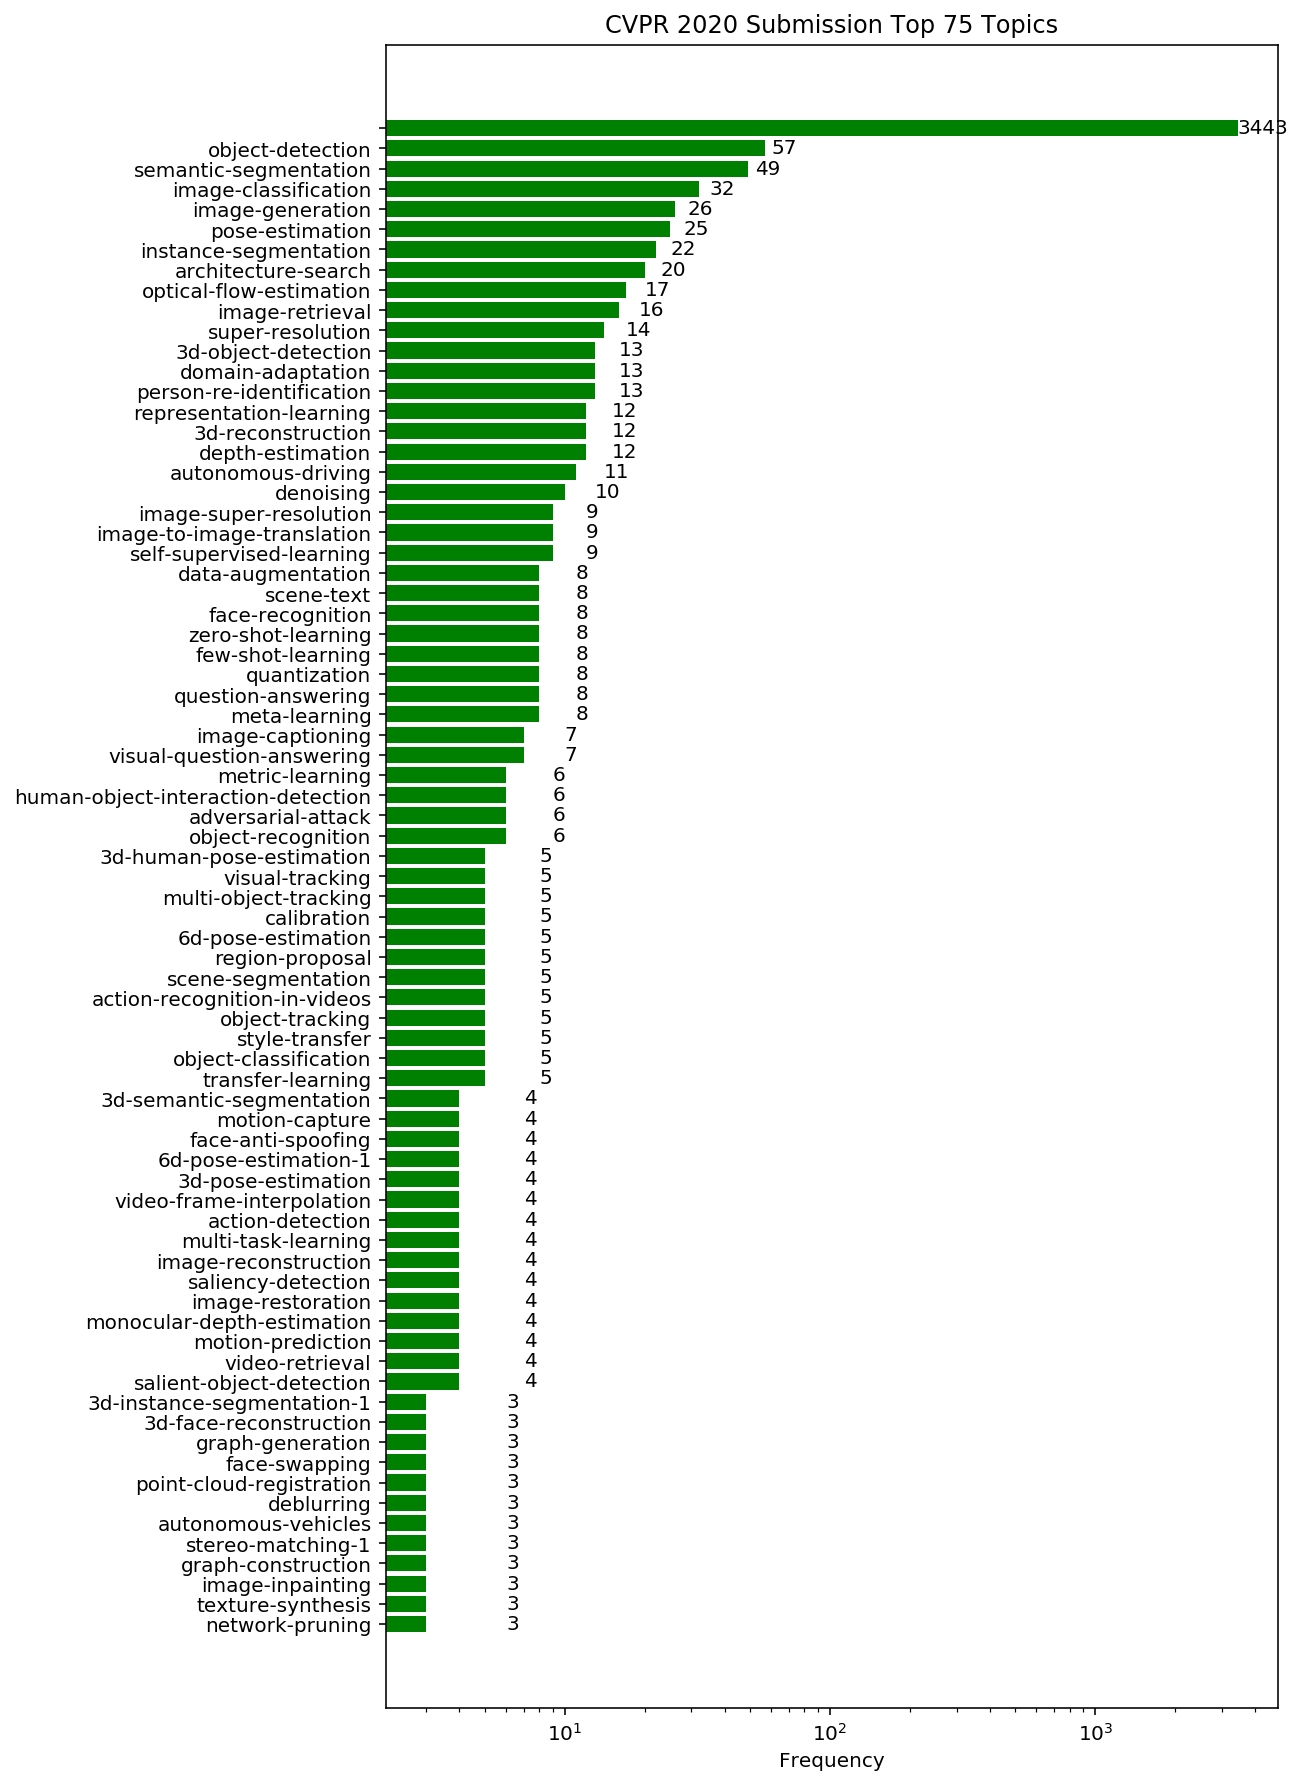

In [46]:
# Show N most common keywords and their frequencies
num_keyowrd = 75
keywords_counter_vis = keyword_counter.most_common(num_keyowrd)

plt.rcdefaults()
fig, ax = plt.subplots(figsize=(8, num_keyowrd//5), dpi=144)

key = [k[0] for k in keywords_counter_vis] 
value = [k[1] for k in keywords_counter_vis] 
y_pos = np.arange(len(key))
ax.barh(y_pos, value, align='center', color='green', ecolor='black', log=True)
ax.set_yticks(y_pos)
ax.set_yticklabels(key, rotation=0, fontsize=10)
ax.invert_yaxis() 
for i, v in enumerate(value):
    ax.text(v + 3, i + .25, str(v), color='black', fontsize=10)
# ax.text(y_pos, value, str(value))
ax.set_xlabel('Frequency')
ax.set_title('CVPR %s Submission Top %d Topics' % (year, num_keyowrd))

plt.savefig('CVPR%s_topics.png' % year)
plt.show()

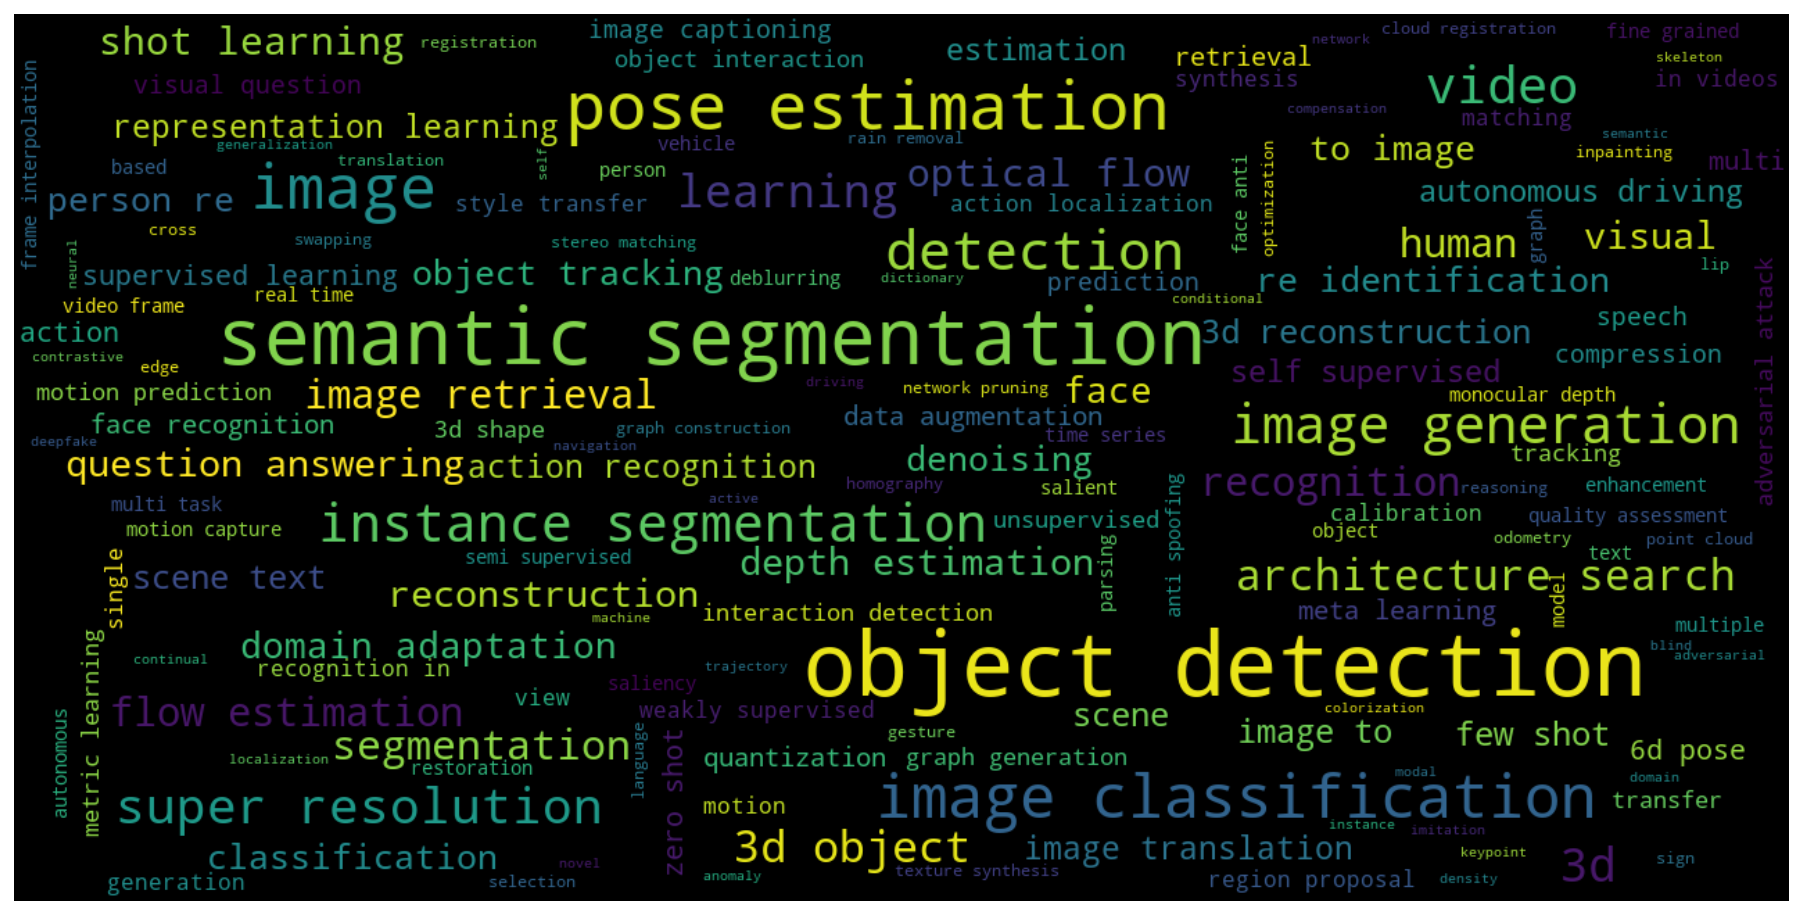

In [45]:
# Show the word cloud forming by keywords
from wordcloud import WordCloud
wordcloud = WordCloud(max_font_size=64, max_words=160, 
                      width=1280, height=640,
                      background_color="black").generate(' '.join(topics_list))
plt.figure(figsize=(16, 8), dpi=144)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig('CVPR%s_wordcloud.png' % year)
plt.show()

## Search papers according to keyword and topic

In [97]:
def pull_papers(paper_infos, topic, search_range='all'):
    target_title = paper_infos[paper_infos['title'].str.contains(topic.capitalize())]

    target_topic = pd.DataFrame()
    for i in range(3):
        tmp = paper_infos[paper_infos['task %d' % (i+1)].str.contains(topic)]
        target_topic = pd.concat([target_topic, tmp]).drop_duplicates()

    if search_range == 'title':
        return target_title
    elif search_range == 'topic':
        return target_topic
    elif search_range == 'all':
        return pd.concat([target_title, target_topic]).drop_duplicates()   


In [98]:
pull_papers(df, 'denoising')

,title,author,task 1,task 2,task 3,github,stars
127,FastDVDnet: Towards Real-Time Deep Video Denoi...,Matias Tassano,denoising,motion-compensation,motion-estimation,https://github.com/m-tassano/fastdvdnet,102
172,A Physics-Based Noise Formation Model for Extr...,Kaixuan Wei,denoising,image-denoising,,https://github.com/Vandermode/NoiseModel,75
238,Supervised Raw Video Denoising With a Benchmar...,Huanjing Yue,denoising,image-denoising,video-denoising,https://github.com/cao-cong/RViDeNet,49
339,Transfer Learning From Synthetic to Real-Noise...,Yoonsik Kim,denoising,transfer-learning,,https://github.com/terryoo/AINDNet,25
684,Event Probability Mask (EPM) and Event Denoisi...,R. Wes Baldwin,,,,,
693,Self2Self With Dropout: Learning Self-Supervis...,Yuhui Quan,,,,,
721,Joint Demosaicing and Denoising With Self Guid...,Lin Liu,,,,,
804,Memory-Efficient Hierarchical Neural Architect...,Haokui Zhang,,,,,
1285,Basis Prediction Networks for Effective Burst ...,Zhihao Xia,,,,,
130,CycleISP: Real Image Restoration via Improved ...,Syed Waqas Zamir,denoising,image-denoising,image-restoration,https://github.com/swz30/CycleISP,98
